In [1]:
import numpy as np
from matplotlib.pyplot import *

In [72]:
########################
# basic STDP functions #
########################

def kernel(t, tau):
    """STDP kernel with timescale tau.
    """
    return np.exp(-t/tau)

def STDP(source_spikes, target_spikes, tau, step_size):
    """Function that calculates change in weight between source and target neuron given their spike trains.
    """
    
    # get spike timings
    ###################
    
    source_idx = np.where(source_spikes == 1)[0]
    target_idx = np.where(target_spikes == 1)[0]
    
    # calculate weight change for each pair of spikes
    #################################################
    
    weight_changes = list()
    for s in source_idx:
        for t in target_idx:
            if t > s:
                weight_changes.append(kernel(t*step_size - s*step_size, tau))
            elif t < s:
                weight_changes.append(-kernel(s*step_size - t*step_size, tau))
                
    return np.sum(weight_changes)

##################################
# average STDP effect calculator #
##################################

def meanSTDP(n_neurons=100, n_timesteps=100, spike_freq=50., step_size=1e-3, connectivity_cutoff=0.8, 
             spike_pdf_stds=[5., 5.], spike_pdf_offsets=[0., 0.], stdp_kernel_tau=3e-3):
    """Function that calculates the average gain in connection strengths between a source and 
       target population given a random, sparse connectivity matrix and gaussian spike distributions 
       around randomly generated spike timings. Distribution of target spikes can have an offset 
       with respect to the source spikes.
    """
    
    # set-up of source + target spike trains and connectivities
    ###########################################################
    
    # calculate spike cutoff
    spike_cutoff = step_size * spike_freq
    
    # generate random spike timings
    spike_timings = np.random.uniform(0, 1, n_timesteps)
    spike_timings[spike_timings > spike_cutoff] = 1
    spike_timings[spike_timings <= spike_cutoff] = 0
    spike_idx = np.where(spike_timings == 1)[0]

    # generate source spike trains
    source_spikes = np.zeros((n_neurons, n_timesteps))
    for idx in spike_idx:
        spike_times = spike_pdf_stds[0] * np.random.randn(n_neurons) + idx + spike_pdf_offsets[0]
        for i, s in enumerate(spike_times):
            if s < timesteps:
                source_spikes[i, int(s)] = 1

    # generate target spike trains
    spread = 5
    target_spikes = np.zeros((n_neurons, n_timesteps))
    for idx in spike_idx:
        spike_times = spike_pdf_stds[1] * np.random.randn(n_neurons) + idx + spike_pdf_offsets[1]
        for i, s in enumerate(spike_times):
            if s < timesteps:
                target_spikes[i, int(s)] = 1

    # generate sparse, random connectivity
    connectivity = np.random.uniform(0, 1, (n_neurons, n_neurons))
    connectivity[connectivity < connectivity_cutoff] = 0.
    
    # apply STDP to spike trains
    ############################

    connectivity_new = connectivity.copy()

    for i in range(n_neurons):
        for j in range(n_neurons):
            if connectivity_new[i, j] > 0.:
                connectivity_new[i, j] += STDP(source_spikes[i], target_spikes[j], tau, step_size)
                
    return np.mean(connectivity - connectivity_new)

In [75]:
#############################################################
# get average weight change for different spike pdf offsets #
#############################################################

# define spike parameters
spike_pdf_stds = [3., 3.]
spike_pdf_offsets = [0., 0.]
target_offsets = np.arange(-5, 5, 1)
n_runs = 3

# calculate average STDP effect for each pdf offset of the target population's spike distribution
stdp_effects = np.zeros((n_runs, len(target_offsets)))
for i, o in enumerate(target_offsets):
    spike_pdf_offsets[1] = o
    for n in range(n_runs):
        stdp_effects[n, i] = meanSTDP(spike_pdf_stds=spike_pdf_stds, spike_pdf_offsets=spike_pdf_offsets)

Text(0,0.5,'mean stdp effect')

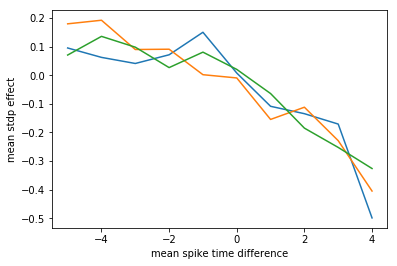

In [77]:
################
# plot results #
################

fig, axes = subplots()
axes.plot(target_offsets, stdp_effects.T)
axes.set_xlabel('mean spike time difference')
axes.set_ylabel('mean stdp effect')

In [83]:
###############################################################
# get average weight change for different spike pdf variances #
###############################################################

# define spike parameters
spike_pdf_offsets = [0., 1.]
pdf_stds = np.arange(1, 11, 2)
n_runs = 1

# calculate average STDP effect for each pdf offset of the target population's spike distribution
stdp_effects = np.zeros((n_runs, len(pdf_stds)))
for i, std in enumerate(pdf_stds):
    spike_pdf_stds = [3., std]
    for n in range(n_runs):
        stdp_effects[n, i] = meanSTDP(spike_pdf_stds=spike_pdf_stds, spike_pdf_offsets=spike_pdf_offsets)

Text(0,0.5,'mean stdp effect')

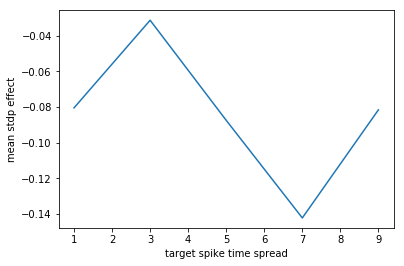

In [84]:
################
# plot results #
################

fig, axes = subplots()
axes.plot(pdf_stds, stdp_effects.T)
axes.set_xlabel('target spike time spread')
axes.set_ylabel('mean stdp effect')